<a href="https://colab.research.google.com/github/Kodhandarama/Audio_Analysis/blob/master/tonic%2Bpitch_histogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#connects colab to drive
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Projects/AA/Code/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import librosa
import librosa.display
from swipe import *
from scipy import signal
import math
from collections import defaultdict, OrderedDict
import statistics
import copy
import json

plt.rcParams['figure.figsize'] = [20,5]
# defining the class 
# each object of this class is an audio clip that is to be analysed
class Audio:
  def __init__(self, path, sr=None, duration = None): 
    # loading the audio file
    self.x, self.sr1 = librosa.load(path= path, sr=sr,duration=duration)
    self.pitch_contour()
    self.constant_pitch()
    self.find_gamaka()
    self.find_stationary_points()
    self.develop_histogram(cpn = True)
    self.tonic = self.find_tonic()
    self.normalize()
    self.develop_histogram(cpn = False)
    self.histogram()
    self.find_all_notes()
    self.sequence_notes = self.find_sequence_notes(self.all_notes)
    self.pattern=self.find_pattern()
  # computing pitch contour
  def pitch_contour(self,dt = 0.01):
    self.pitch, self.time_axis, self.s = swipe(self.x,self.sr1,[100, 500],dt, 0.4)
    
  def constant_pitch(self ):
    
    time_axis_80 = []
    pitch_80 = []
    constant_pitch_time_80=[]
  
    for i in range(0,len(self.time_axis),8):
      pitch_80.append(self.pitch[i])
      time_axis_80.append(self.time_axis[i])
    delta = 12
      
    diff_80 = np.diff(pitch_80)

    for i in range(len(diff_80)):
      # constant note when the slope(of the pitch contour) is within the thershold i.e, delta =  
      if(diff_80[i]<delta/2 and diff_80[i]>-delta/2):
        constant_pitch_time_80.append(time_axis_80[i])
    self.constant_pitch_time_80 = np.array(constant_pitch_time_80)

    cpt = list(self.constant_pitch_time_80.round(2))
    tim = []
    initial = cpt[0]
    c= initial
    for i in range(1,len(cpt)):
      check = round(cpt[i]-c,2)
      if(check == 0.08):
        pass
      else:
        tim.append((initial,c))
        initial = cpt[i]
      if i == (len(cpt)-1):
        c= cpt[i]
        tim.append((initial,c))
      c= cpt[i]
    ta = list(self.time_axis)
    self.cpn_and_t = []
    for i in tim:
      begin = int(100*i[0])
      end = int(100*i[1])
      self.cpn_and_t.append((self.pitch[begin:end],ta[begin:end]))
    self.cpn_and_t = np.array(self.cpn_and_t)
    g,h = self.cpn_and_t.T
    self.cpn = np.array([item for sublist in g for item in sublist])
    self.cpt = np.array([item for sublist in h for item in sublist])
  
  def find_all_notes(self):  
    self.all_notes = []
    for i in self.n_pitch:
      if i in self.n_cpn or i in self.n_stp:
        self.all_notes.append(i)

  def find_gamaka(self):
    
    ta = list(self.time_axis)
    bt_cpt = []
    init = 0
    for _,j in self.cpn_and_t:
      if(j):
        bt_cpt.append([init,j[0]])
        init = j[-1]
    bt_cpn_cpt=[]
    for i in bt_cpt:
          begin = int(100*i[0])
          end = int(100*i[1])
          bt_cpn_cpt.append((self.pitch[begin:end],ta[begin:end]))
    self.bt_cpn_cpt = np.array(bt_cpn_cpt)
    self.bt_cpn,self.bt_cpt = self.bt_cpn_cpt.T
  
  def find_stationary_points(self):
    self.stp = []
    self.stp_t = []
    for i in range(len(self.bt_cpn)):
      test = self.bt_cpn[i]
      test_time  = self.bt_cpt[i]
      for i in signal.find_peaks(test)[0]:
        self.stp.append(test[i])
        self.stp_t.append(test_time[i])
      for i in signal.find_peaks(-1*test)[0]:
        self.stp.append(test[i])
        self.stp_t.append(test_time[i])
  def develop_histogram(self,cpn):
    if(cpn):
      values=[x for x in self.cpn if (math.isnan(x) == False)]
      initial = 120
      end = 500
      increment = 1
      r = 0
    else:
      values = [x for x in self.n_pitch if (math.isnan(x) == False)]
      initial = all_normalized_notes['lSa0']
      end = all_normalized_notes['hNi3']
      increment = 0.01
      r = 2
    values=[round(x,r) for x in values]
    occur=dict()
    self.d_hist=defaultdict(int)
    for i in values:
      if(i in occur):
        occur[i]+=1;
      else:
        occur[i]=1;
    j=initial
    while(j<=end):
      # print(j)
      if(j in occur):
        self.d_hist[j]=occur[j]
        # times.append(occur[j])
      else:
        self.d_hist[j]=0
      j+=increment
      j = round(j,r)

  def find_tonic(self):
  
    def close_5(arr):
      if(len(arr)<4):
        return(arr)
      top5=list()

      for i in arr:
        count=0
        for j in arr:
          if(abs(i-j)<16):
            count+=1
        if (count>len(arr)/3):
          top5.append(i)
      return(top5)

    def tonic_candidates_f():
        #histo is a dictionary
        self.candidates=defaultdict(int)
        local_histo = copy.deepcopy(self.d_hist)

        for i in range(44):
          highest=0
          freq = 0
          for i in local_histo:
            if(local_histo[i]>highest):
              highest = local_histo[i]
              freq=i
          self.candidates[freq] = highest
          try:
            del local_histo[freq] 
          except KeyError:
            # print("Nothing to delete")
            pass
          
        # print("occurances for 298 :",histo[298])
        # print("The candidates are : ",candidates.keys())
        return(list(self.candidates.keys()))
   
    def remove_outliers(an_array):
      if(len(an_array)<3):
        return(an_array)
      else:  
        mean=statistics.mean(an_array)
        an_array = np.array(an_array)
        # mean = np.mean(an_array)
        standard_deviation = np.std(an_array)
        distance_from_mean = abs(an_array - mean)
        max_deviations = 0.9
        not_outlier = distance_from_mean <= 1.1* max_deviations * standard_deviation
        no_outliers = an_array[not_outlier]

        return(no_outliers)
    # def close(arr):
    #   flag=0
    #   min_diff =45000
    #   ele1=0;ele2=0
    #   for i in range(len(arr)):
    #     for j in range(i+1,len(arr)):
    #       if(abs(arr[i]-arr[j])<5 and abs(arr[i]-arr[j])<min_diff):
    #         ele1=arr[i]
    #         ele2=arr[j]
    #         flag=1
    #   if(flag==0):    
    #     return min(arr)
    #   return(ele1,ele2) 
    
    def half_the_Sa(ton):

      if(ton>242):
        return (ton/2)
      else:
        return ton
  
    self.Sa_candidates=defaultdict(list)
    tonic_candidates=tonic_candidates_f() 
    #+ self.stp
    for i in tonic_candidates:
      for j in tonic_candidates :
            if(((i/j)>1.48) and ((i/j) <1.51)):
              self.Sa_candidates["Pa"].append(half_the_Sa(j))
            if(((i/j)>1.06) and ((i/j) <1.067)):
              self.Sa_candidates["Ri1"].append(half_the_Sa(j))
            if(((i/j)>1.19) and ((i/j) <1.21)):
              self.Sa_candidates["Ga2"].append(half_the_Sa(j))
              
            if(((i/j)>1.12) and ((i/j) <1.127) ):
              self.Sa_candidates["Ri2"].append(half_the_Sa(j))

            if(((i/j)>1.4) and ((i/j) <1.42) ):
              self.Sa_candidates["Ma2"].append(half_the_Sa(j))
              
            if(((i/j)>1.31) and ((i/j) <1.34) ):
              self.Sa_candidates["Ma1"].append(half_the_Sa(j))
             
            if(((i/j)>1.23) and ((i/j) <1.27)):
              self.Sa_candidates["Ga3"].append(half_the_Sa(j))
            if(((i/j)>1.59) and ((i/j) <1.61)):
              self.Sa_candidates["Da1"].append(half_the_Sa(j))
              
            if(((i/j)>1.86) and ((i/j) <1.91) ):
              self.Sa_candidates["Ni3"].append(half_the_Sa(j))
            if(((i/j)>1.78) and ((i/j) <1.82) ):
              self.Sa_candidates["Ni2"].append(half_the_Sa(j))
            if(i>200):  
              if(((i/j)>1.98) and ((i/j) <2.2) ):
                self.Sa_candidates["High_Sa"].append(half_the_Sa(j))
            if(j>200):
              #Pa
              if(((i/j)>0.74) and ((i/j) <0.76) ):
                self.Sa_candidates["High_Sa"].append(half_the_Sa(j/2))
              #Da2
              if(((i/j)>0.82) and ((i/j) <0.85) ):
                self.Sa_candidates["High_Sa"].append(half_the_Sa(j/2))
              #Ma
              if(((i/j)>0.65) and ((i/j) <0.68) ):
                self.Sa_candidates["High_Sa"].append(half_the_Sa(j/2))
    # print("The Sa_candidates are : ",(Sa_candidates)) 
    for i in self.Sa_candidates:
      self.Sa_candidates[i]=remove_outliers(self.Sa_candidates[i])
      self.Sa_candidates[i]=close_5(self.Sa_candidates[i])

    if("Pa" in self.Sa_candidates):
      if(len(self.Sa_candidates["Pa"])!=0):
            Pa= mean(self.Sa_candidates["Pa"])
            if("High_Sa" in self.Sa_candidates):
              if(len(self.Sa_candidates["High_Sa"])!=0):
                        for i in range (int(Pa-4),int(Pa+4)):
                          if(i in self.Sa_candidates["High_Sa"]):
                            High_Sa=Pa
                            return(Pa)
                        else:
                          High_Sa = mean((self.Sa_candidates["High_Sa"]))
                        # print("x :",x)
                        # High_Sa=mean(x)

                        if(abs(High_Sa-Pa)<5 and (Pa +High_Sa)>0):
                        #and (High_Sa+Pa) != 0
                            prob = High_Sa
                            return(prob)     
                            
    
    for i in self.Sa_candidates:
      print("i :",i, " Sa_candidates[i] :", self.Sa_candidates[i])
        # print("i :",i, " Sa_candidates[i] :", Sa_candidates[i])
      if(len(self.Sa_candidates[i])!=0):
          self.Sa_candidates[i]=mean(self.Sa_candidates[i])
          
   
 
    temp=[i for i in list(self.Sa_candidates.values()) if(i)]
    # print("Temp :",temp)
    temp2=remove_outliers(temp)
    finallist=close_5(temp2)
    # print("Sa_candidates : ", finallist)
    # two_tonic=close(finallist)
    # print("two_tonic :",two_tonic)
    # if(type(two_tonic) ==tuple):
      # print("Tonic: ", half_the_Sa(((two_tonic[0])+((two_tonic[1])))/2))
      # return(half_the_Sa(((two_tonic[0])+((two_tonic[1])))/2))
    # else:
      # print("Tonic : ",half_the_Sa(two_tonic))
    if(not(np.isnan(half_the_Sa(mean(finallist))))):
      return((half_the_Sa(mean(finallist))))
      print("Tonic :",(half_the_Sa(mean(finallist))))
    else:
      print("Tonic not found")
      return -1
  def histogram(self):
    self.hist_bins,self.hist_y = np.array(list(self.d_hist.items())).T
    self.n_hist_y = self.hist_y/len(self.pitch)

  def normalize(self):
    self.n_pitch = [12*np.log2(i/self.tonic) for i in self.pitch]
    # self.n_bt_cpn = [12*np.log2(j/self.tonic) for i in self.bt_cpn for j in i]
    self.n_bt_cpn = []
    for i in self.bt_cpn:
      self.n_bt_cpn.append([12*np.log2(j/self.tonic) for j in i])
    self.n_stp = [12*np.log2(i/self.tonic) for i in self.stp]
    self.n_cpn = [12*np.log2(i/self.tonic) for i in self.cpn]
  
  def find_sequence_notes(self,parameter):
    notes = []
    for k in parameter:
   
      if k in self.n_cpn:
        a = 0.04
      else:
        a = 0.135
      for i,j in all_normalized_notes.items():
        if (math.isclose(j,k,abs_tol= a)):
          notes.append(i)
    set_note = []
    initial = notes[0]
    set_note.append(initial)
    for i in range(1,len(notes)):
      if (initial != notes[i]):
        initial = notes[i]
        set_note.append(initial)
    return set_note
  def find_pattern(self):
    def countme(l,sl):
      count =0
      for i in range(0,len(l)):
        a=l[i:i+len(sl)]
        if (a==sl):
          count+=1
      return(count)
    cnt=0
    pattern=dict()
    for sublen in range(3,int(4)):
      for i in range(0,len(self.sequence_notes)-sublen):
        sub = self.sequence_notes[i:i+sublen]
        if(len(set(sub))>1):
          cnt = countme(self.sequence_notes,sub)
          str1=""
          strsub=str1.join(sub)
          if cnt >= (4) and strsub not in pattern:
            pattern[strsub] = cnt
    return pattern
  def plot(self,**kwargs):
    for key,value in kwargs.items():
      if(key=='contour' and value):
        plt.plot(self.time_axis,self.n_pitch,label = 'Pitch Contour')
      if(key == 'cpn' and value):
        plt.plot(self.time_axis,self.n_pitch,c="#FF0000",label = 'Pitch Contour')
        plt.scatter(self.cpt,self.n_cpn,c='0',label = 'Constant Pitch')
      if(key =='stp' and value):
        plt.scatter(self.stp_t,self.n_stp,c='#00FF00',label = 'Stationary Points')
        plt.plot(self.time_axis,self.n_pitch,c="#FF0000",label = 'Pitch Contour')
      if(key =='histogram' and value):
        plt.plot(self.hist_bins,  self.n_hist_y,label = "histogram")
      plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)


ratios = {'Sa0':1,'Ri1':16/15,'Ri2':9/8,'Ga2':6/5,'Ga3':5/4,'Ma1':4/3,'Ma2':17/12,'Pa0':3/2,'Da1':8/5,
          'Da2':5/3,'Ni2':9/5,'Ni3':15/8,'Sa2':2}
all_normalized_notes = dict()
for i,j in ratios.items():
  all_normalized_notes[i] = 12*np.log2(j)
  all_normalized_notes['l'+i] = 12*np.log2(0.5*j)
  all_normalized_notes['h'+i] = 12*np.log2(2*j)

del all_normalized_notes['lSa2']
del all_normalized_notes['hSa0']
all_normalized_notes = OrderedDict(sorted(all_normalized_notes.items(),key=lambda kv: kv[1]))

In [0]:
minimumm=10000
cntcnt=0
for i in range(5,30):
  for j in range(10,100):
    for k in range(235,245):
      value = (abs(find_tonic(rkm_abhogi,i,j,k)-149.4)+abs(find_tonic(rkm_kalyani,i,j,k)-149.4)+abs(find_tonic(rkm_sahana,i,j,k)-149.4)+abs(find_tonic(rkm_saveri,i,j,k)-(149.4))+abs(find_tonic(rkm_shree,i,j,k)-(149.4))+abs(find_tonic(badri_kalyani,i,j,k)-(138.59))+abs(find_tonic(badri_mohana,i,j,k)-(138.59))+abs(find_tonic(badri_saveri,i,j,k)-(138.59))+abs(find_tonic(badri_shree,i,j,k)-(138.59))+abs(find_tonic(prasanna_kalyani,i,j,k)-(146.83))+abs(find_tonic(prasanna_abhogi,i,j,k)-(146.83))+abs(find_tonic(prasanna_begada,i,j,k)-(146.83))+abs(find_tonic(prasanna_savveri,i,j,k)-(146.83))+abs(find_tonic(vignesh_kalyani,i,j,k)-(138.59))+abs(find_tonic(vignesh_abhogi,i,j,k)-(138.59))+abs(find_tonic(vignesh_sahana,i,j,k)-(138.59))+abs(find_tonic(vignesh_shree,i,j,k)-(138.59))+abs(find_tonic(dharini_abhogi,i,j,k)-(200.58))+abs(find_tonic(dharini_mohana,i,j,k)-(200.58)))
      cntcnt=cntcnt+1
      print(cntcnt)
      if(value<minimumm):
        minimumm = value
        opt=(i,j,k)
print(opt)


In [0]:
badrinarayanan: 138.59
dharini: 200.58
prasanna: 146.83
ramakrishnamurthy: 149.4
sreevidya: 210.07
vignesh: 138.59

rkm_mohana - If there are common elements in Pa and Sa, use that to advantage
rkm_shree - 
,badri_mohana,badri_shree,prasanna_kalyani,prasanna_abhogi,prasanna_begada,prasanna_mohana,vignesh_sahana,vignesh_shree,dharini_sahana,dharini_mohana,dharini_saveri,sreeevidya_abhogi,sreevidya_sahana

In [0]:
sreevidya_saveri.tonic

212.0

In [0]:
badri_kalyani2 = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223586__gopalkoduri__carnatic-varnam-by-badrinarayanan-in-kalyani-raaga.mp3')

i : High_Sa  Sa_candidates[i] : [102.5, 103.0, 102.0, 104.0, 104.5, 105.0, 103.5, 102.5, 103.0, 102.0, 103.5, 100.5, 101.0, 101.5, 102.5, 103.0, 102.0, 104.0, 103.5, 101.0, 101.5, 102.5, 103.0, 102.0, 100.5, 101.0, 101.5, 100.5, 101.0, 101.5, 102.0, 100.5, 101.0, 101.5, 102.5, 103.0, 102.0, 104.0, 104.5, 103.5, 101.5, 102.5, 103.0, 104.0, 104.5, 105.0, 103.5, 105.5, 106.0, 105.0, 105.5, 106.0, 106.5, 102.5, 103.0, 102.0, 103.5, 100.5, 101.0, 101.5, 102.5, 103.0, 102.0, 104.0, 104.5, 105.0, 103.5, 101.0, 101.5, 104.0, 104.5, 105.0, 105.5, 106.0, 106.5, 102.5, 103.0, 102.0, 104.0, 104.5, 103.5, 100.5, 101.0, 101.5, 102.5, 103.0, 102.0, 101.0, 101.5, 104.0, 104.5, 105.0, 105.5, 106.0, 106.5, 102.5, 103.0, 102.0, 104.0, 104.5, 105.0, 103.5, 101.5, 105.5, 106.0, 103.0, 104.0, 104.5, 105.0, 103.5, 105.5, 106.0, 106.5, 106.5, 102.5, 103.0, 102.0, 104.0, 103.5, 101.5, 104.0, 104.5, 105.0, 103.5, 105.5, 106.0, 104.0, 104.5, 105.0, 105.5, 106.0, 106.5, 103.0, 104.0, 104.5, 105.0, 103.5, 105.5, 1

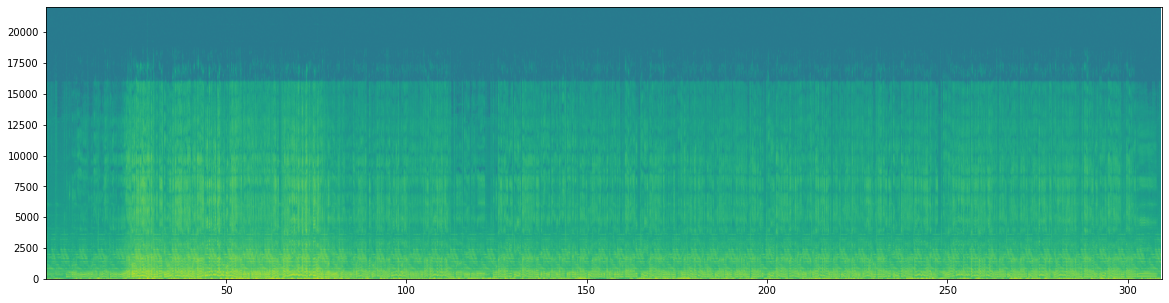

In [0]:
badri_mohana2 = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223590__gopalkoduri__carnatic-varnam-by-badrinarayanan-in-mohanam-raaga.mp3')

i : High_Sa  Sa_candidates[i] : [138.0, 139.0, 137.0, 136.0, 135.0, 138.0, 139.0, 137.0, 136.0, 135.0, 138.0, 137.0, 136.0, 135.0, 138.0, 137.0, 136.0, 135.0, 138.0, 139.0, 137.0, 136.0, 140.0, 141.0, 135.0, 136.0, 135.0, 138.0, 138.5, 137.5, 137.0, 140.0, 140.5, 139.5, 139.0, 136.5, 138.5, 140.0, 140.5, 139.5, 139.0, 136.0, 135.0, 138.0, 138.5, 137.5, 137.0, 140.0, 140.5, 139.5, 139.0, 138.0, 138.5, 137.5, 137.0, 140.0, 135.5, 140.5, 139.5, 139.0, 136.0, 136.5, 138.0, 138.5, 137.5, 137.0, 140.0, 140.5, 139.5, 139.0, 138.0, 138.5, 140.0, 140.5, 139.5, 139.0, 138.0, 139.0, 137.0, 136.0, 140.0, 141.0, 135.0, 138.0, 138.5, 137.5, 137.0, 135.5, 135.0, 136.0, 136.5, 138.0, 138.5, 140.0, 140.5, 139.5, 139.0, 140.0, 140.5, 139.5, 139.0, 140.5, 140.0, 140.5, 139.5, 138.0, 139.0, 137.0, 136.0, 140.0, 135.0, 138.5, 140.0, 140.5, 139.5, 139.0, 138.0, 139.0, 137.0, 136.0, 140.0, 135.0, 137.0, 136.0, 135.0, 138.0, 138.5, 137.5, 137.0, 140.0, 135.5, 135.0, 140.5, 139.5, 139.0, 136.0, 136.5, 138.0, 1

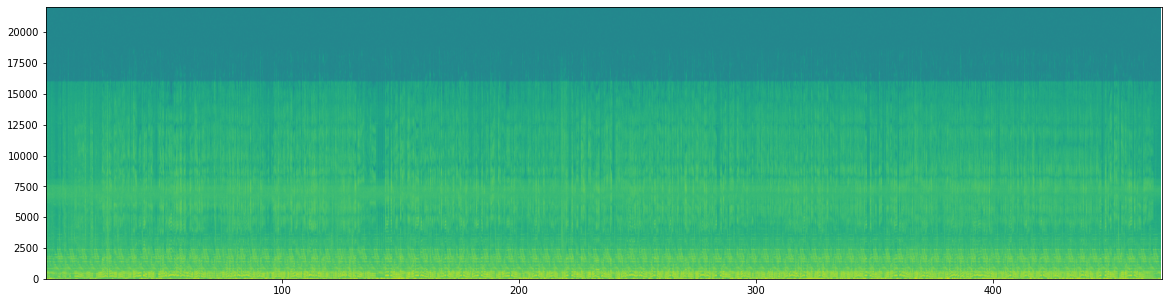

In [0]:
badri_shree2 = Audio("/content/drive/My Drive/Projects/AA/Music dataset/Audio/223603__gopalkoduri__carnatic-varnam-by-badrinarayanan-in-sri-raaga.mp3")

i : High_Sa  Sa_candidates[i] : [147.0, 147.5, 146.5, 146.0, 144.5, 145.0, 145.5, 167.5, 167.0, 168.0, 147.0, 147.0, 147.0, 147.5, 148.0, 146.5, 146.0, 145.0, 148.5, 145.5, 167.5, 167.0, 168.0, 168.5, 147.0, 146.5, 146.0, 144.5, 145.0, 145.5, 167.5, 143.5, 144.0, 167.0, 147.0, 147.0, 147.5, 148.0, 146.5, 146.0, 149.0, 148.5, 145.5, 167.5, 167.0, 168.0, 168.5, 147.0, 147.0, 147.5, 148.0, 146.5, 149.0, 148.5, 149.5, 167.5, 167.0, 168.0, 168.5, 170.0, 147.0, 147.0, 147.5, 148.0, 149.0, 148.5, 149.5, 167.5, 150.0, 167.0, 168.0, 150.5, 168.5, 170.0, 147.0, 150.0, 146.5, 146.0, 144.5, 145.0, 145.5, 143.5, 143.0, 144.0, 147.5, 148.0, 149.0, 148.5, 149.5, 167.5, 150.0, 167.0, 168.0, 150.5, 168.5, 170.0, 147.0, 144.5, 145.0, 145.5, 143.5, 143.0, 144.0, 147.0, 150.0, 170.0, 144.5, 145.0, 143.5, 143.0, 144.0, 141.5, 142.0, 168.5, 170.0, 144.5, 143.5, 143.0, 144.0, 141.5, 141.0, 142.0, 149.0, 148.5, 149.5, 167.5, 150.0, 167.0, 168.0, 150.5, 168.5, 170.0, 147.0, 150.0, 170.0, 167.5, 167.0, 168.0, 1

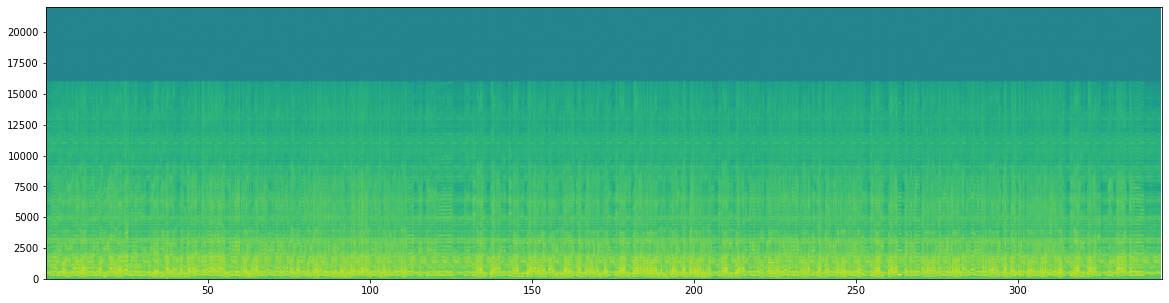

In [0]:
prasanna_kalyani2 = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223587__gopalkoduri__carnatic-varnam-by-prasanna-in-kalyani-raaga.mp3')

i : Pa  Sa_candidates[i] : [197.0, 196.0, 199.0, 198.0, 197.0, 196.0, 198.0, 195.0, 197.0, 199.0, 198.0, 200.0, 199.0, 201.0, 198.0, 197.0, 200.0, 199.0, 198.0, 197.0, 196.0, 195.0, 200.0, 199.0, 201.0, 202.0, 197.0, 196.0, 195.0, 194.0, 195.0, 194.0, 200.0, 199.0, 201.0, 202.0]
i : Ni2  Sa_candidates[i] : [163, 165, 164, 163, 165, 164, 163, 165, 166, 164, 165, 166, 164, 165, 166, 164, 163, 164, 165, 166, 163, 164, 165, 166]
i : High_Sa  Sa_candidates[i] : [147.5, 147.0, 148.0, 149.0, 148.5, 146.5, 149.5, 146.0, 150.0, 167.0, 163.0, 168.0, 165.0, 166.0, 164.0, 162.0, 147.5, 147.0, 148.0, 149.0, 148.5, 146.5, 149.5, 146.0, 144.5, 150.0, 167.0, 169.0, 163.0, 168.0, 165.0, 166.0, 164.0, 162.0, 147.5, 148.0, 149.0, 148.5, 149.5, 150.0, 147.5, 147.0, 148.0, 149.0, 148.5, 146.5, 149.5, 150.0, 167.0, 163.0, 168.0, 165.0, 166.0, 164.0, 162.0, 148.0, 149.0, 148.5, 149.5, 150.0, 147.5, 147.0, 148.0, 149.0, 148.5, 146.5, 149.5, 146.0, 150.0, 147.5, 147.0, 148.0, 149.0, 148.5, 146.5, 149.5, 146.0,

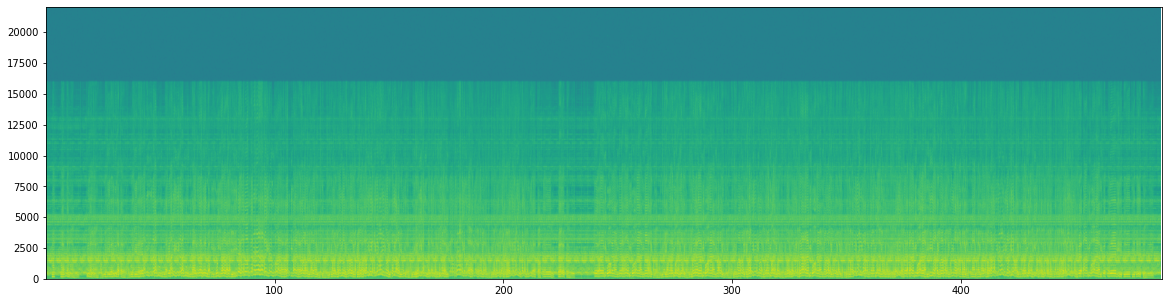

In [0]:
prasanna_abhogi2 = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223579__gopalkoduri__carnatic-varnam-by-prasanna-in-abhogi-raaga.mp3')
prasanna_begada2 = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223583__gopalkoduri__carnatic-varnam-by-prasanna-in-begada-raaga.mp3')

In [0]:
prasanna_begada2.tonic

135.05823863636363

In [0]:
prasanna_abhogi2.tonic

159.96287566137568

In [0]:
badri_shree2.tonic

151.06122448979593

In [0]:
prasanna_kalyani2.tonic

214.65160098522165

In [0]:
rkm_mohana2.tonic

149.58823529411765

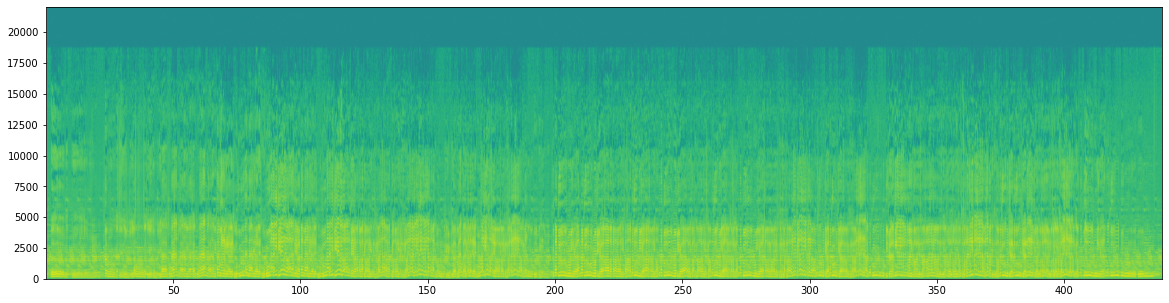

In [69]:
rkm_sahana=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223595__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-sahana-raaga.mp3')

In [70]:
rkm_sahana.tonic

152.56

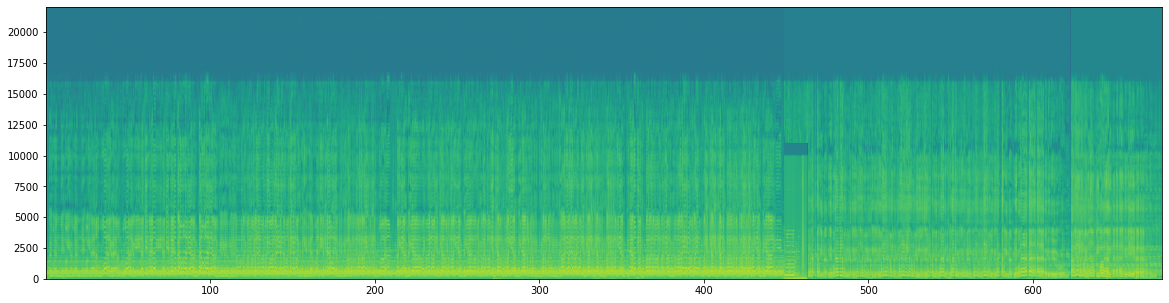

In [0]:
rkm_abhogi=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223580__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-abhogi-raaga.mp3')
rkm_kalyani=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223588__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-kalyani-raaga.mp3')
rkm_mohana=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223593__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-mohanam-raaga.mp3')
rkm_sahana=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223595__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-sahana-raaga.mp3')
rkm_saveri=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223601__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-saveri-raaga.mp3')
rkm_shree=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223604__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-sri-raaga.mp3')
#badri_kalyani = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223586__gopalkoduri__carnatic-varnam-by-badrinarayanan-in-kalyani-raaga.mp3')
#badri_mohana = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223590__gopalkoduri__carnatic-varnam-by-badrinarayanan-in-mohanam-raaga.mp3')
badri_saveri = Audio("/content/drive/My Drive/Projects/AA/Music dataset/Audio/223598__gopalkoduri__carnatic-varnam-by-badrinarayanan-in-saveri-raaga.mp3")
#badri_shree = Audio("/content/drive/My Drive/Projects/AA/Music dataset/Audio/223603__gopalkoduri__carnatic-varnam-by-badrinarayanan-in-sri-raaga.mp3")
# prasanna_kalyani = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223587__gopalkoduri__carnatic-varnam-by-prasanna-in-kalyani-raaga.mp3')
# prasanna_abhogi = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223579__gopalkoduri__carnatic-varnam-by-prasanna-in-abhogi-raaga.mp3')
# prasanna_begada = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223583__gopalkoduri__carnatic-varnam-by-prasanna-in-begada-raaga.mp3')
prasanna_savveri = Audio("/content/drive/My Drive/Projects/AA/Music dataset/Audio/223600__gopalkoduri__carnatic-varnam-by-prasanna-in-saveri-raaga.mp3")
# prasanna_mohana = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223592__gopalkoduri__carnatic-varnam-by-prasanna-in-mohanam-raaga.mp3')
vignesh_kalyani= Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223589__gopalkoduri__carnatic-varnam-by-vignesh-in-kalyani-raaga.mp3')
vignesh_abhogi = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223582__gopalkoduri__carnatic-varnam-by-vignesh-in-abhogi-raaga.mp3')
vignesh_begada = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223585__gopalkoduri__carnatic-varnam-by-vignesh-in-begada-raaga.mp3')
vignesh_sahana = Audio("/content/drive/My Drive/Projects/AA/Music dataset/Audio/223597__gopalkoduri__carnatic-varnam-by-vignesh-in-sahana-raaga.mp3")
# vignesh_shree = Audio("/content/drive/My Drive/Projects/AA/Music dataset/Audio/223605__gopalkoduri__carnatic-varnam-by-vignesh-in-sri-raaga.mp3")
dharini_abhogi = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223578__gopalkoduri__carnatic-varnam-by-dharini-in-abhogi-raaga.mp3')
# dharini_sahana = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223594__gopalkoduri__carnatic-varnam-by-dharini-in-sahana-raaga.mp3')
# dharini_mohana = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223591__gopalkoduri__carnatic-varnam-by-dharini-in-mohanam-raaga.mp3')
# dharini_saveri = Audio("/content/drive/My Drive/Projects/AA/Music dataset/Audio/223599__gopalkoduri__carnatic-varnam-by-dharini-in-saveri-raaga.mp3")
sreeevidya_abhogi = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223581__gopalkoduri__carnatic-varnam-by-sreevidya-in-abhogi-raaga.mp3')
sreevidya_begada = Audio("/content/drive/My Drive/Projects/AA/Music dataset/Audio/223584__gopalkoduri__carnatic-varnam-by-sreevidya-in-begada-raaga.mp3")
sreevidya_sahana = Audio("/content/drive/My Drive/Projects/AA/Music dataset/Audio/223596__gopalkoduri__carnatic-varnam-by-sreevidya-in-sahana-raaga.mp3")
sreevidya_saveri = Audio("/content/drive/My Drive/Projects/AA/Music dataset/Audio/223602__gopalkoduri__carnatic-varnam-by-sreevidya-in-saveri-raaga.mp3")

In [0]:
def find_tonic(obj):
  def close_5(arr):
    top5=list()
    for i in arr:
      count=0
      for j in arr:
        if(abs(i-j)<16):
          count+=1
      if (count>len(arr)/2):
        top5.append(i)
    return(top5)

  def tonic_candidates_f(obj):
      #histo is a dictionary
      candidates=defaultdict(int)
      local_histo = (develop_histogram(obj))

      for i in range(44):
        highest=0
        freq = 0
        for i in local_histo:
          if(local_histo[i]>highest):
            highest = local_histo[i]
            freq=i
        if (highest != 0):
          candidates[freq] = highest
        try:
            del local_histo[freq] 
        except KeyError:
            print("Nothing to delete")
         
      # print("occurances for 298 :",histo[298])
      # print("The candidates are : ",candidates.keys())
      return(candidates.keys())
  
  def remove_outliers(an_array):
    if(len(an_array)<3):
      return(an_array)
    else:  
      mean=statistics.mean(an_array)
      an_array = np.array(an_array)
      # mean = np.mean(an_array)
      standard_deviation = np.std(an_array)
      distance_from_mean = abs(an_array - mean)
      max_deviations = 0.9
      not_outlier = distance_from_mean <= 1.1* max_deviations * standard_deviation
      no_outliers = an_array[not_outlier]

      return(no_outliers)
  # def close(arr):
  #   flag=0
  #   min_diff =45000
  #   ele1=0;ele2=0
  #   for i in range(len(arr)):
  #     for j in range(i+1,len(arr)):
  #       if(abs(arr[i]-arr[j])<5 and abs(arr[i]-arr[j])<min_diff):
  #         ele1=arr[i]
  #         ele2=arr[j]
  #         flag=1
  #   if(flag==0):    
  #     return min(arr)
  #   return(ele1,ele2) 
  
  def half_the_Sa(ton):

    if(ton>242):
      return (ton/2)
    else:
      return ton

  Sa_candidates=defaultdict(list)
  tonic_candidates=tonic_candidates_f(obj)
  for i in tonic_candidates:
    for j in tonic_candidates :
          if(((i/j)>1.48) and ((i/j) <1.51)):
            Sa_candidates["Pa"].append(half_the_Sa(j))
          if(((i/j)>1.06) and ((i/j) <1.067)):
            Sa_candidates["Ri1"].append(half_the_Sa(j))
          if(((i/j)>1.19) and ((i/j) <1.21)):
            Sa_candidates["Ga2"].append(half_the_Sa(j))
            
          if(((i/j)>1.12) and ((i/j) <1.127) ):
            Sa_candidates["Ri2"].append(half_the_Sa(j))

          if(((i/j)>1.4) and ((i/j) <1.42) ):
            Sa_candidates["Ma2"].append(half_the_Sa(j))
            
          if(((i/j)>1.31) and ((i/j) <1.34) ):
            Sa_candidates["Ma1"].append(half_the_Sa(j))
            
          if(((i/j)>1.23) and ((i/j) <1.27)):
            Sa_candidates["Ga3"].append(half_the_Sa(j))
          if(((i/j)>1.59) and ((i/j) <1.61)):
            Sa_candidates["Da1"].append(half_the_Sa(j))
            
          if(((i/j)>1.86) and ((i/j) <1.91) ):
            Sa_candidates["Ni3"].append(half_the_Sa(j))
          if(((i/j)>1.78) and ((i/j) <1.82) ):
            Sa_candidates["Ni2"].append(half_the_Sa(j))
          if(i>200):  
            if(((i/j)>1.98) and ((i/j) <2.2) ):
              Sa_candidates["High_Sa"].append(half_the_Sa(j))
          if(j>200):
            #Pa
            if(((i/j)>0.74) and ((i/j) <0.76) ):
              Sa_candidates["High_Sa"].append(half_the_Sa(j/2))
            #Da2
            if(((i/j)>0.82) and ((i/j) <0.85) ):
              Sa_candidates["High_Sa"].append(half_the_Sa(j/2))
            #Ma
            if(((i/j)>0.65) and ((i/j) <0.68) ):
              Sa_candidates["High_Sa"].append(half_the_Sa(j/2))
  # print("The Sa_candidates are : ",(Sa_candidates)) 
  for i in Sa_candidates:
    Sa_candidates[i]=remove_outliers(Sa_candidates[i])
    Sa_candidates[i]=close_5(Sa_candidates[i])

  if("Pa" in Sa_candidates):
    if(len(Sa_candidates["Pa"])!=0):
          Pa= mean(Sa_candidates["Pa"])
          if("High_Sa" in Sa_candidates):
            if(len(Sa_candidates["High_Sa"])!=0):

                    # if(Pa in self.Sa_candidates["High_Sa"]):
                    #   High_Sa=Pa
                    # else:
                      High_Sa = mean((Sa_candidates["High_Sa"]))
                      # print("x :",x)
                      # High_Sa=mean(x)

                      if(abs(High_Sa-Pa)<5 ):
                        #and (High_Sa+Pa) != 0
                            prob = High_Sa
                            return(prob)     
                          
  
  for i in Sa_candidates:
    # print("i :",i, " Sa_candidates[i] :", Sa_candidates[i])
      # print("i :",i, " Sa_candidates[i] :", Sa_candidates[i])
    if(len(Sa_candidates[i])!=0):
        Sa_candidates[i]=mean(Sa_candidates[i])
        
  

  temp=[i for i in list(Sa_candidates.values()) if(i)]
  # print("Temp :",temp)
  temp2=remove_outliers(temp)
  finallist=close_5(temp2)
  # print("Sa_candidates : ", finallist)
  # two_tonic=close(finallist)
  # print("two_tonic :",two_tonic)
  # if(type(two_tonic) ==tuple):
    # print("Tonic: ", half_the_Sa(((two_tonic[0])+((two_tonic[1])))/2))
    # return(half_the_Sa(((two_tonic[0])+((two_tonic[1])))/2))
  # else:
    # print("Tonic : ",half_the_Sa(two_tonic))
  if(not(np.isnan(half_the_Sa(mean(finallist))))):
    print((half_the_Sa(mean(finallist))))
    return((half_the_Sa(mean(finallist))))

  else:
    print("Tonic not found")

# find_tonic(rkm_shree)

In [0]:
class Compare_Audio:

  def __init__(self,audio1,audio2):
       self.audio1=audio1
       self.audio2=audio2
    # self.index = 0.1*((audio1.tonic -audio2.tonic)**2)+ 0.3*()

  def compare_tonic(self):

    self.tonic_index=(self.audio1.tonic - self.audio2.tonic)**2

    return self.tonic_index

  def compare_pattern(self):
    compare1= list(self.audio1.pattern.values())
    compare2= list(self.audio2.pattern.values())

    unnormalized_ratio=0

    for i in compare1:
      if (i in compare2):
        unnormalized_ratio += 1
    normalized_ratio = (unnormalized_ratio)/(min(len(compare1),compare2))

    return normalized_ratio


In [0]:
first = Compare_Audio(rkm_kalyani,saveri)

In [0]:
rkm_shree.tonic

167.0

In [0]:
print((((rkm_shree.Sa_candidates["High_Sa"]))))

143.95275590551182


In [0]:
print(vignesh_abhogi.tonic)
print(vignesh_kalyani.tonic)
# print(rkm_mohana.tonic)
print(vignesh_sahana.tonic)
# print(rkm_saveri.tonic)
print(vignesh_shree.tonic)
print(vignesh_begada.tonic)

139.0917207792208
137.0
138.6195652173913
151.43833333333333
172.87


badrinarayanan: 138.59
dharini: 200.58
prasanna: 146.83
ramakrishnamurthy: 149.4
sreevidya: 210.07
vignesh: 138.59

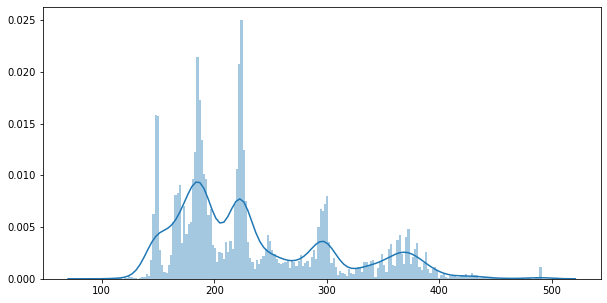

In [0]:
#checking out smooth histograms
import seaborn as sns

# test2=Audio('/content/drive/My Drive/AA/Music dataset/Raga_Surabhi_3.wav')
free= rkm_mohana.pitch
plt.rcParams['figure.figsize'] = [10, 5]
# sns.set_style('darkgrid')
sns.distplot(free,bins=200)

In [0]:
free2= test2.pitch
plt.rcParams['figure.figsize'] = [10, 5]
# sns.set_style('darkgrid')
sns.distplot(free2,bins=20)

https://pages.mtu.edu/~suits/notefreqs.html

In [0]:
most_frequent([i for i in rkm2.pitch if i>320 and i<325])

In [0]:
#distance metric

import numpy as np
import scipy.stats


def jensen_shannon_distance(p, q):
    """
    method to compute the Jenson-Shannon Distance 
    between two probability distributions
    """

    # convert the vectors into numpy arrays in case that they aren't
    p = np.array(p)
    q = np.array(q)

    # calculate m
    m = (p + q) / 2

    # compute Jensen Shannon Divergence
    divergence = (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m)) / 2

    # compute the Jensen Shannon Distance
    distance = np.sqrt(divergence)

    return distance

# jensen_shannon_distance([1,2,3,4,5],[4,8,12,16,20])

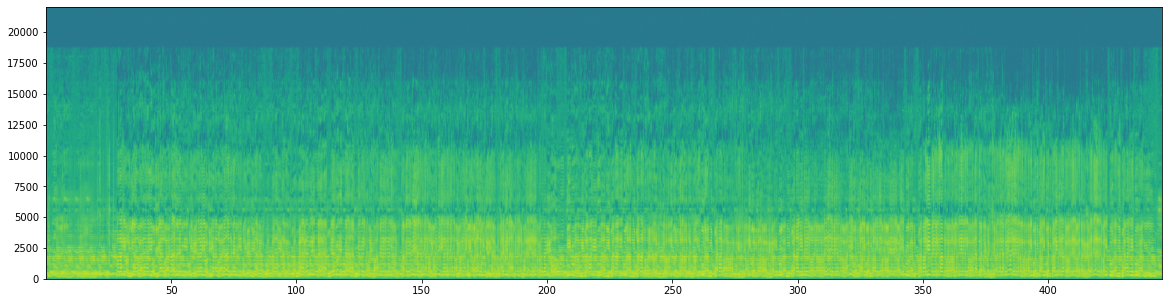

In [0]:
# kalyani1=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/Raga_Kalyani_1.wav')
# kalyani2=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/Raga_Kalyani_2.wav')
# rkm_abhogi=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223580__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-abhogi-raaga.mp3')
rkm_kalyani=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223588__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-kalyani-raaga.mp3')
# rkm_mohana=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223593__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-mohanam-raaga.mp3')
# rkm_sahana=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223595__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-sahana-raaga.mp3')
# rkm_saveri=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223601__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-saveri-raaga.mp3')
# rkm_shree=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223604__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-sri-raaga.mp3')
# rkm_dwija=Audio('/content/drive/My Drive/Projects/AA/Music dataset/rkm_new.mp3')

In [0]:
tmk_jaya=Audio('/content/drive/My Drive/Projects/AA/Music dataset/TMK/tmk_jaya.mp3')
tmk_malika=Audio('/content/drive/My Drive/Projects/AA/Music dataset/TMK/tmk_malika.mp3')
tmk_thodi=Audio('/content/drive/My Drive/Projects/AA/Music dataset/TMK/tmk_thodi.mp3')
tmk_shankara=Audio('/content/drive/My Drive/Projects/AA/Music dataset/TMK/tmk_shankara.mp3')
tmk_nata=Audio('/content/drive/My Drive/Projects/AA/Music dataset/TMK/tmk_nata.mp3')

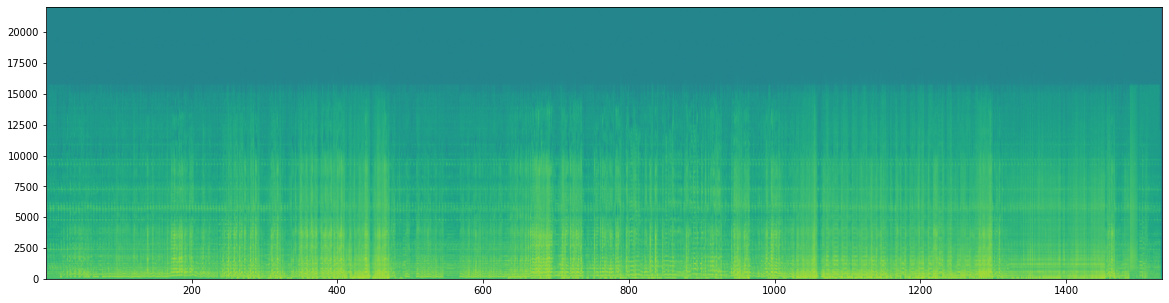

In [0]:
tmk_maya=Audio('/content/drive/My Drive/Projects/AA/Music dataset/TMK/tmk_maya.mp3')

In [0]:
from collections import defaultdict
from statistics import mean
def find_tonic(tonic_candidates):
   
    def remove_outliers(an_array):
      if(len(an_array)<3):
        return(an_array)
      else:  
        an_array = np.array(an_array)
        mean = np.mean(an_array)
        standard_deviation = np.std(an_array)
        distance_from_mean = abs(an_array - mean)
        max_deviations = 0.9
        not_outlier = distance_from_mean <1.1* max_deviations * standard_deviation
        no_outliers = an_array[not_outlier]

        return(no_outliers)
    def close(arr):
      flag=0
      min_diff =45000
      ele1=0;ele2=0
      for i in range(len(arr)):
        for j in range(i+1,len(arr)):
          if(abs(arr[i]-arr[j])<5 and abs(arr[i]-arr[j])<min_diff):
            ele1=arr[i]
            ele2=arr[j]
            flag=1
      if(flag==0):    
        return min(arr)
      return(ele1,ele2) 
      
    Sa_candidates=defaultdict(list)

    def half_the_Sa(ton):

      if(ton>230):
        return (ton/2)
      else:
        return ton
        
    for i in tonic_candidates:
      for j in tonic_candidates :
            if(((i/j)>1.48) and ((i/j) <1.51)):
              Sa_candidates["Pa"].append(j)
            if(((i/j)>1.06) and ((i/j) <1.08)):
              Sa_candidates["Ri1"].append(j)
            if(((i/j)>1.9) and ((i/j) <1.21)):
              Sa_candidates["Ga2"].append(j)
              
            if(((i/j)>1.12) and ((i/j) <1.127) ):
              Sa_candidates["Ri2"].append(j)

            if(((i/j)>1.4) and ((i/j) <1.42) ):
              Sa_candidates["Ma2"].append(j)
              
            if(((i/j)>1.31) and ((i/j) <1.34) ):
              Sa_candidates["Ma1"].append(j)
             
            if(((i/j)>1.23) and ((i/j) <1.27)):
              Sa_candidates["Ga3"].append(j)
            if(((i/j)>1.57) and ((i/j) <1.62)):
              Sa_candidates["Da1"].append(j)
              
            if(((i/j)>1.86) and ((i/j) <1.88) ):
              Sa_candidates["Ni3"].append(j)
            if(((i/j)>1.78) and ((i/j) <1.82) ):
              Sa_candidates["Ni2"].append(j)
              
            if(((i/j)>1.98) and ((i/j) <2.2) ):
              Sa_candidates["High_Sa"].append(j)
    # print("The Sa_candidates are : ",(Sa_candidates))  
    if("Pa" in Sa_candidates):

        if("High_Sa" not in Sa_candidates):
          Sa_candidates["High_Sa"] =[0]   
          High_Sa=0
        else:
     
          High_Sa = mean(remove_outliers(Sa_candidates["High_Sa"]))
      
        Pa = mean(remove_outliers(Sa_candidates["Pa"]))
        
        if(abs(High_Sa-Pa)<3 and (High_Sa+Pa) != 0):
          print("Tonic by Pa : ", half_the_Sa(min(High_Sa,Pa)))
          return(half_the_Sa(min(High_Sa,Pa)))     
          a=5
    without_pa=[]
    for i in Sa_candidates:
      # print("i :",i, " Sa_candidates[i] :", Sa_candidates[i])
      if(Sa_candidates[i]):
        if(len(Sa_candidates[i])==1):
          a=5
        if(len(Sa_candidates[i])==0):
          Sa_candidates[i].append(0)
          # without_pa.append(Sa_candidates[i][0])
        elif(len(Sa_candidates[i])!=0):
            Sa_candidates[i]=remove_outliers(Sa_candidates[i])
          # without_pa.extend(Sa_candidates[i])
      
        # print("i :",i, " Sa_candidates[i] :", Sa_candidates[i])
        if(len(Sa_candidates[i])!=0):
        
          Sa_candidates[i]=mean(Sa_candidates[i])
          
    # print("without_pa : ",remove_outliers(without_pa))  
    
    # print(list(Sa_candidates.values()))

 
    temp=[i for i in list(Sa_candidates.values()) if(i)]
    # print("Temp :",temp)
    finallist=remove_outliers(temp)
    # print("Sa_candidates : ", finallist)
    two_tonic=close(finallist)
    # print("two_tonic :",two_tonic)
    if(type(two_tonic) ==tuple):
      print("Tonic: ", half_the_Sa(((two_tonic[0])+((two_tonic[1])))/2))
    else:
      print("Tonic : ",half_the_Sa(two_tonic))
  

    # candidates=list(Sa_candidates.values())
    # candidates=(remove_outliers(candidates))
    # print("To be returned : ", candidates)

# ratios = {'Sa':1,'Ri1':1.066667,'Ri2/Ga1':1.125,'Ga2/Ri3':1.2,'Ga3':1.25,'Ma1':1.33333,'Ma2':1.4166667,'Pa':1.5,'Da1':1.6,
          # 'Da2/Ni1':1.66667,'Ni2/Da3':1.8,'Ni3':1.875,'Sa2':2}

# find_tonic(tonic_abhogi)
# find_tonic(tonic_kalyani)
# find_tonic(tonic_mohana)
# find_tonic(tonic_sahana)
# find_tonic(tonic_saveri)
# find_tonic(tonic_shree)
# find_tonic(tonic_vishwa)
# find_tonic(tonic_dwija)


find_tonic(tonic_jaya)
find_tonic(tonic_malika)
find_tonic(tonic_nata)
find_tonic(tonic_shankara)
find_tonic(tonic_thodi)
find_tonic(tonic_maya)


Tonic:  139.0
Tonic:  139.125
Tonic by Pa :  138
Tonic:  138.5
Tonic:  101.0
Tonic by Pa :  137


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


137

In [0]:
def remove_outliers(an_array):
  # if()
  an_array = np.array(an_array)
  mean = np.mean(an_array)
  standard_deviation = np.std(an_array)
  print(standard_deviation)
  distance_from_mean = abs(an_array - mean)
  max_deviations = 0.9
  not_outlier = distance_from_mean <=1.1*max_deviations * standard_deviation
  no_outliers = an_array[not_outlier]

  return(no_outliers)

remove_outliers(remove_outliers([111.5, 112.0, 111.0, 112.5, 113.0, 110.5, 113.5, 110.0, 114.0, 100.5, 111.5, 112.0, 111.0, 112.5, 113.0, 110.5, 113.5, 114.0, 100.5, 111.5, 112.0, 111.0, 112.5, 113.0, 110.5, 113.5, 110.0, 109.5, 111.5, 112.0, 111.0, 112.5, 110.5, 110.0, 100.5, 111.5, 112.0, 112.5, 113.0, 113.5, 114.0, 100.5, 149.5, 150.0, 149.0, 150.5, 148.0, 148.5, 147.5, 111.5, 112.0, 111.0, 110.5, 110.0, 100.5, 109.5, 149.5, 150.0, 149.0, 150.5, 148.0, 148.5, 151.0, 147.5, 112.0, 112.5, 113.0, 113.5, 114.0, 100.5, 149.5, 149.0, 148.0, 148.5, 147.5, 111.0, 110.5, 110.0, 100.5, 109.5, 111.5, 112.0, 111.0, 112.5, 113.0, 113.5, 100.5, 149, 150, 148, 147, 151, 146, 149.5, 150.0, 149.0, 150.5, 148.5, 151.0, 111.5, 112.0, 111.0, 112.5, 113.0, 110.5, 110.0, 109.5, 149, 150, 148, 147, 151, 146, 149.5, 150.0, 149.0, 150.5, 151.0, 111.5, 112.0, 112.5, 113.0, 113.5, 114.0, 100.5, 149, 150, 148, 147, 146, 110.5, 110.0, 109.5, 149, 150, 148, 147, 151, 146, 149, 148, 147, 146, 149.0, 148.0, 148.5, 147.5, 149.5, 150.0, 150.5, 151.0, 149.5, 150.0, 149.0, 150.5, 148.0, 148.5, 151.0, 147.5, 149, 148, 147, 146, 149, 150, 148, 147, 151, 146, 114.0, 148.0, 148.5, 147.5, 113.0, 113.5, 114.0, 149.5, 150.0, 149.0, 150.5, 148.0, 148.5, 151.0, 147.5, 149.5, 150.0, 149.0, 150.5, 148.0, 148.5, 151.0, 147.5, 110.0, 109.5, 150.5, 151.0, 149.5, 150.0, 149.0, 150.5, 148.0, 148.5, 151.0, 148, 147, 146, 111.5, 112.0, 111.0, 110.5, 110.0, 109.5, 149.5, 150.0, 149.0, 150.5, 148.0, 148.5, 151.0, 147.5, 113.5, 114.0, 147.5]))

19.12053303984501
11.937077992023926


array([149.5, 150. , 149. , 150.5, 148. , 148.5, 147.5, 149.5, 150. ,
       149. , 150.5, 148. , 148.5, 147.5, 149.5, 149. , 148. , 148.5,
       147.5, 149. , 150. , 148. , 147. , 146. , 149.5, 150. , 149. ,
       150.5, 148.5, 149. , 150. , 148. , 147. , 146. , 149.5, 150. ,
       149. , 150.5, 149. , 150. , 148. , 147. , 146. , 149. , 150. ,
       148. , 147. , 146. , 149. , 148. , 147. , 146. , 149. , 148. ,
       148.5, 147.5, 149.5, 150. , 150.5, 149.5, 150. , 149. , 150.5,
       148. , 148.5, 147.5, 149. , 148. , 147. , 146. , 149. , 150. ,
       148. , 147. , 146. , 148. , 148.5, 147.5, 149.5, 150. , 149. ,
       150.5, 148. , 148.5, 147.5, 149.5, 150. , 149. , 150.5, 148. ,
       148.5, 147.5, 150.5, 149.5, 150. , 149. , 150.5, 148. , 148.5,
       148. , 147. , 146. , 149.5, 150. , 149. , 150.5, 148. , 148.5,
       147.5, 147.5])

In [0]:
def close(arr):

  min_diff =45000
  ele1=0;ele2=0
  
  for i in range(len(arr)):
    for j in range(i+1,len(arr)):
      if(abs(arr[i]-arr[j])<5 and abs(arr[i]-arr[j])<min_diff):
        ele1=arr[i]
        ele2=arr[j]
      else:
        return(min(arr))
  return(ele1,ele2)
close([208.,  278.,  278.5])

208.0

In [0]:
# shank_plain=Audio('/content/shank_plain.mp3')
# shank_gamak=Audio('/content/shank_gamak.mp3')
mayamala=Audio('/content/mayamala.mp3')

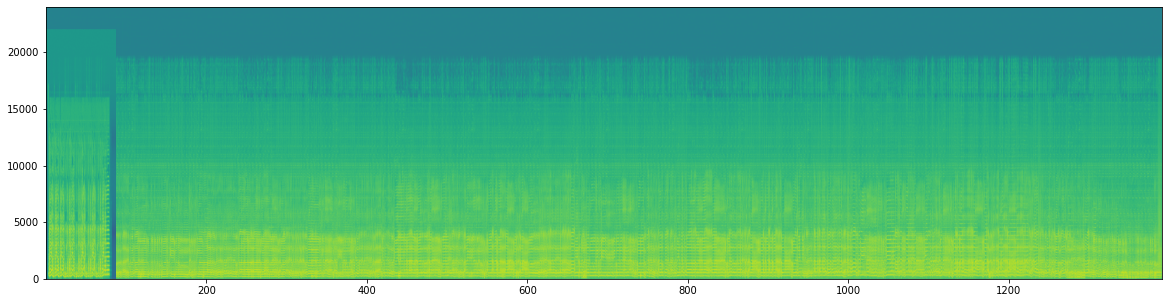

In [0]:
trichur_kalyani= Audio('/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/trichur_kalyani.mp3')
kalyani_1=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/Raga_Kalyani_1.wav')
kalyani_2=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/Raga_Kalyani_2.wav')
# kalyani_ms=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/kalyani_ms.mp3')
# kalyani_sesha=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/kalyani_sesha.mp3')

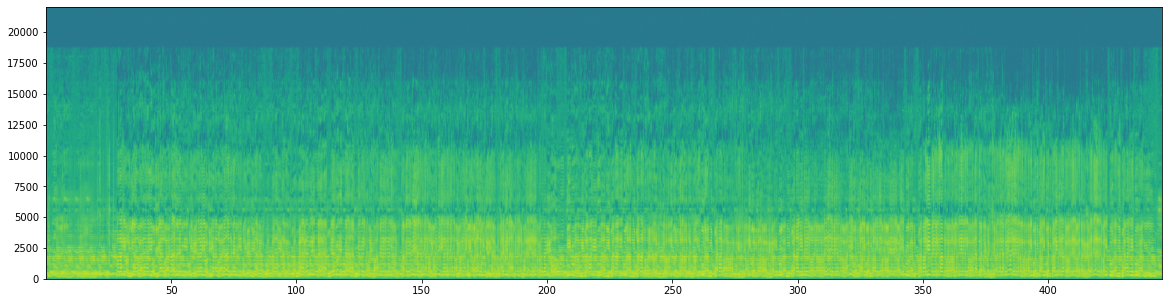

In [0]:
# kalyani1=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/Raga_Kalyani_1.wav')
# kalyani2=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/Raga_Kalyani_2.wav')
# rkm_abhogi=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223580__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-abhogi-raaga.mp3')
rkm_kalyani=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223588__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-kalyani-raaga.mp3')
# rkm_mohana=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223593__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-mohanam-raaga.mp3')
# rkm_sahana=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223595__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-sahana-raaga.mp3')
# rkm_saveri=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223601__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-saveri-raaga.mp3')
# rkm_shree=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223604__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-sri-raaga.mp3')
# rkm_dwija=Audio('/content/drive/My Drive/Projects/AA/Music dataset/rkm_new.mp3')

In [0]:
rkm_kalyani.__dict__

In [0]:


def find_pattern(self.sequence_notes):
  def countme(l,sl):
    count =0
    for i in range(0,len(l)):
      a=l[i:i+len(sl)]
      if (a==sl):
        count+=1
    return(count)
  cnt=0
  pattern=dict()
  for sublen in range(3,int(4)):
    for i in range(0,len(s)-sublen):
      sub = self.sequence_notes[i:i+sublen]
      if(len(set(sub))>1):
        cnt = countme(self.sequence_notes,sub)
        str1=""
        strsub=str1.join(sub)
        if cnt >= (4) and strsub not in pattern:
          pattern[strsub] = cnt
  return pattern

In [0]:
pattern(rkm_kalyani.sequence_notes)

{'Ma2Pa0Ma2': 21, 'Ni3Sa2Ni3': 26, 'Pa0Ma2Pa0': 35, 'Sa2Ni3Sa2': 35}

In [0]:
len(rkm_kalyani.sequence_notes)

1888

In [0]:
sorted_x = sorted(x.items(), key=lambda kv: kv[1])

In [0]:
len(rkm_kalyani.sequence_notes)

1888

In [0]:
len(kalyani_1.sequence_notes)

172

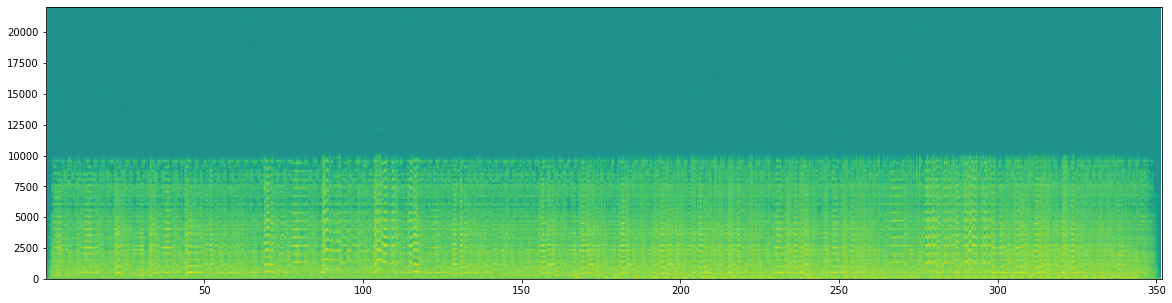

In [0]:
fminsb = Audio('/content/drive/My Drive/Projects/AA/Music dataset/5mins/5minsSB.mp3')

In [0]:
len(fminsb.sequence_notes)

238

In [0]:
fminsb.tonic

168.15

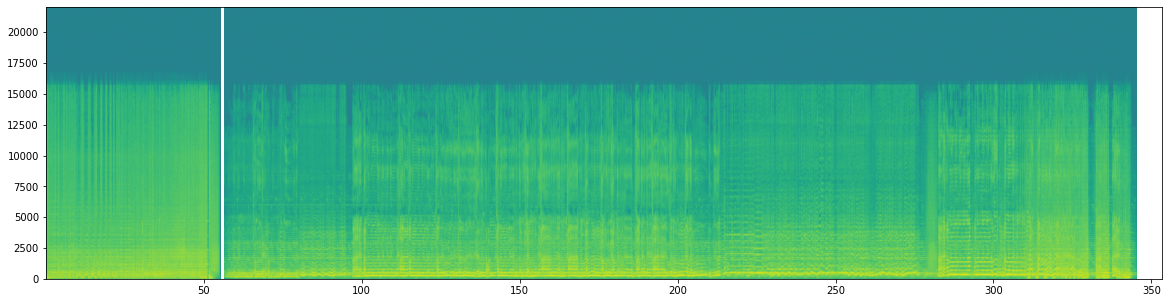

In [0]:
fminsp = Audio('/content/drive/My Drive/Projects/AA/Music dataset/5mins/5minsSP.mp3')

In [0]:
len(fminsp.sequence_notes)

1220

In [0]:
fminsp.tonic

171.44444444444446

In [0]:
fminsp.find_pattern()

{'Da1Da2Da1': 8,
 'Da1Da2Ni2': 5,
 'Da1Ma1Ma2': 4,
 'Da1Ma2Da1': 4,
 'Da1Ni2Da2': 7,
 'Da1Pa0Da1': 12,
 'Da1Pa0Da2': 4,
 'Da1Pa0Ma2': 14,
 'Da2Da1Da2': 5,
 'Da2Da1Ma2': 4,
 'Da2Da1Ni2': 6,
 'Da2Da1Pa0': 8,
 'Da2Ma2Pa0': 4,
 'Da2Ni2Da2': 10,
 'Da2Pa0Da1': 6,
 'Da2Pa0Ma2': 5,
 'Ga3Ma1Ma2': 4,
 'Ma1Ga3Ga2': 6,
 'Ma1Ma2Ma1': 6,
 'Ma1Ma2Pa0': 19,
 'Ma1Pa0Da1': 6,
 'Ma1Pa0Ma1': 5,
 'Ma1Pa0Ma2': 8,
 'Ma2Da1Pa0': 6,
 'Ma2Da2Da1': 4,
 'Ma2Ma1Ga3': 6,
 'Ma2Ma1Pa0': 4,
 'Ma2Pa0Da1': 14,
 'Ma2Pa0Da2': 6,
 'Ma2Pa0Ma1': 16,
 'Ma2Pa0Ma2': 34,
 'Ma2Pa0Ri1': 4,
 'Ni2Da2Da1': 8,
 'Ni2Da2Ni2': 6,
 'Ni2Ni3Ni2': 8,
 'Ni2hRi1hGa2': 4,
 'Ni3Ni2Ni3': 8,
 'Ni3Sa2Ni3': 4,
 'Pa0Da1Da2': 5,
 'Pa0Da1Ni2': 5,
 'Pa0Da1Ni3': 4,
 'Pa0Da1Pa0': 21,
 'Pa0Da2Pa0': 5,
 'Pa0Ma1Ga3': 4,
 'Pa0Ma1Ma2': 11,
 'Pa0Ma1Pa0': 7,
 'Pa0Ma2Da1': 5,
 'Pa0Ma2Ma1': 12,
 'Pa0Ma2Pa0': 48,
 'Ri1Ga2Ri2': 4,
 'Ri2Ma1Pa0': 5,
 'hGa2hGa3hGa2': 13,
 'hGa2hGa3hMa2': 6,
 'hGa2hMa1hMa2': 7,
 'hGa2hRi1hGa2': 4,
 'hGa2hRi2hGa2': 10,
 'hGa3hGa2hGa3': 5

In [0]:
def close_5(arr):
  top5=list()
  for i in arr:
    count=0
    for j in arr:
      if(abs(i-j)<5):
        count+=1
    if (count>len(arr)/2):
      top5.append(i)
  return(top5)    
close_5([111.5, 112.0, 111.0, 112.5, 113.0, 110.5, 113.5, 110.0, 114.0, 100.5, 111.5, 112.0, 111.0, 112.5, 113.0, 110.5, 113.5, 114.0, 100.5, 111.5, 112.0, 111.0, 112.5, 113.0, 110.5, 113.5, 110.0, 109.5, 111.5, 112.0, 111.0, 112.5, 110.5, 110.0, 100.5, 111.5, 112.0, 112.5, 113.0, 113.5, 114.0, 100.5, 149.5, 150.0, 149.0, 150.5, 148.0, 148.5, 147.5, 111.5, 112.0, 111.0, 110.5, 110.0, 100.5, 109.5, 149.5, 150.0, 149.0, 150.5, 148.0, 148.5, 151.0, 147.5, 112.0, 112.5, 113.0, 113.5, 114.0, 100.5, 149.5, 149.0, 148.0, 148.5, 147.5, 111.0, 110.5, 110.0, 100.5, 109.5, 111.5, 112.0, 111.0, 112.5, 113.0, 113.5, 100.5, 149, 150, 148, 147, 151, 146, 149.5, 150.0, 149.0, 150.5, 148.5, 151.0, 111.5, 112.0, 111.0, 112.5, 113.0, 110.5, 110.0, 109.5, 149, 150, 148, 147, 151, 146, 149.5, 150.0, 149.0, 150.5, 151.0, 111.5, 112.0, 112.5, 113.0, 113.5, 114.0, 100.5, 149, 150, 148, 147, 146, 110.5, 110.0, 109.5, 149, 150, 148, 147, 151, 146, 149, 148, 147, 146, 149.0, 148.0, 148.5, 147.5, 149.5, 150.0, 150.5, 151.0, 149.5, 150.0, 149.0, 150.5, 148.0, 148.5, 151.0, 147.5, 149, 148, 147, 146, 149, 150, 148, 147, 151, 146, 114.0, 148.0, 148.5, 147.5, 113.0, 113.5, 114.0, 149.5, 150.0, 149.0, 150.5, 148.0, 148.5, 151.0, 147.5, 149.5, 150.0, 149.0, 150.5, 148.0, 148.5, 151.0, 147.5, 110.0, 109.5, 150.5, 151.0, 149.5, 150.0, 149.0, 150.5, 148.0, 148.5, 151.0, 148, 147, 146, 111.5, 112.0, 111.0, 110.5, 110.0, 109.5, 149.5, 150.0, 149.0, 150.5, 148.0, 148.5, 151.0, 147.5, 113.5, 114.0, 147.5])

[149.5,
 150.0,
 149.0,
 150.5,
 148.0,
 148.5,
 147.5,
 149.5,
 150.0,
 149.0,
 150.5,
 148.0,
 148.5,
 151.0,
 147.5,
 149.5,
 149.0,
 148.0,
 148.5,
 147.5,
 149,
 150,
 148,
 147,
 151,
 149.5,
 150.0,
 149.0,
 150.5,
 148.5,
 151.0,
 149,
 150,
 148,
 147,
 151,
 149.5,
 150.0,
 149.0,
 150.5,
 151.0,
 149,
 150,
 148,
 147,
 149,
 150,
 148,
 147,
 151,
 149,
 148,
 147,
 149.0,
 148.0,
 148.5,
 147.5,
 149.5,
 150.0,
 150.5,
 151.0,
 149.5,
 150.0,
 149.0,
 150.5,
 148.0,
 148.5,
 151.0,
 147.5,
 149,
 148,
 147,
 149,
 150,
 148,
 147,
 151,
 148.0,
 148.5,
 147.5,
 149.5,
 150.0,
 149.0,
 150.5,
 148.0,
 148.5,
 151.0,
 147.5,
 149.5,
 150.0,
 149.0,
 150.5,
 148.0,
 148.5,
 151.0,
 147.5,
 150.5,
 151.0,
 149.5,
 150.0,
 149.0,
 150.5,
 148.0,
 148.5,
 151.0,
 148,
 147,
 149.5,
 150.0,
 149.0,
 150.5,
 148.0,
 148.5,
 151.0,
 147.5,
 147.5]

In [0]:
def find_tonic(self):
  
    def close_5(arr):
    top5=list()
    for i in arr:
      count=0
      for j in arr:
        if(abs(i-j)<5):
          count+=1
      if (count>len(arr)/2):
        top5.append(i)
    return(top5)

    def tonic_candidates_f():
        #histo is a dictionary
        self.candidates=defaultdict(int)
        local_histo = copy.deepcopy(self.d_hist)

        for i in range(40):
          highest=0
          freq = 0
          for i in local_histo:
            if(local_histo[i]>highest):
              highest = local_histo[i]
              freq=i
          self.candidates[freq] = highest
          del local_histo[freq]  
        # print("occurances for 298 :",histo[298])
        # print("The candidates are : ",candidates.keys())
        return(self.candidates.keys())
   
    def remove_outliers(an_array):
      if(len(an_array)<3):
        return(an_array)
      else:  
        mean=statistics.mean(an_array)
        an_array = np.array(an_array)
        # mean = np.mean(an_array)
        standard_deviation = np.std(an_array)
        distance_from_mean = abs(an_array - mean)
        max_deviations = 0.9
        not_outlier = distance_from_mean <= 1.1* max_deviations * standard_deviation
        no_outliers = an_array[not_outlier]

        return(no_outliers)
    def close(arr):
      flag=0
      min_diff =45000
      ele1=0;ele2=0
      for i in range(len(arr)):
        for j in range(i+1,len(arr)):
          if(abs(arr[i]-arr[j])<5 and abs(arr[i]-arr[j])<min_diff):
            ele1=arr[i]
            ele2=arr[j]
            flag=1
      if(flag==0):    
        return min(arr)
      return(ele1,ele2) 
    
    def half_the_Sa(ton):

      if(ton>240):
        return (ton/2)
      else:
        return ton
  
    self.Sa_candidates=defaultdict(list)
    tonic_candidates=tonic_candidates_f()
    for i in tonic_candidates:
      for j in tonic_candidates :
            if(((i/j)>1.48) and ((i/j) <1.51)):
              self.Sa_candidates["Pa"].append(half_the_Sa(j))
            if(((i/j)>1.06) and ((i/j) <1.067)):
              self.Sa_candidates["Ri1"].append(half_the_Sa(j))
            if(((i/j)>1.19) and ((i/j) <1.21)):
              self.Sa_candidates["Ga2"].append(half_the_Sa(j))
              
            if(((i/j)>1.12) and ((i/j) <1.127) ):
              self.Sa_candidates["Ri2"].append(half_the_Sa(j))

            if(((i/j)>1.4) and ((i/j) <1.42) ):
              self.Sa_candidates["Ma2"].append(half_the_Sa(j))
              
            if(((i/j)>1.31) and ((i/j) <1.34) ):
              self.Sa_candidates["Ma1"].append(half_the_Sa(j))
             
            if(((i/j)>1.23) and ((i/j) <1.27)):
              self.Sa_candidates["Ga3"].append(half_the_Sa(j))
            if(((i/j)>1.59) and ((i/j) <1.61)):
              self.Sa_candidates["Da1"].append(half_the_Sa(j))
              
            if(((i/j)>1.86) and ((i/j) <1.91) ):
              self.Sa_candidates["Ni3"].append(half_the_Sa(j))
            if(((i/j)>1.78) and ((i/j) <1.82) ):
              self.Sa_candidates["Ni2"].append(half_the_Sa(j))
            if(i>200):  
              if(((i/j)>1.98) and ((i/j) <2.2) ):
                self.Sa_candidates["High_Sa"].append(half_the_Sa(j))
            if(j>200):
              #Pa
              if(((i/j)>0.74) and ((i/j) <0.76) ):
                self.Sa_candidates["High_Sa"].append(half_the_Sa(j/2))
              #Da2
              if(((i/j)>0.82) and ((i/j) <0.85) ):
                self.Sa_candidates["High_Sa"].append(half_the_Sa(j/2))
              #Ma
              if(((i/j)>0.65) and ((i/j) <0.68) ):
                self.Sa_candidates["High_Sa"].append(half_the_Sa(j/2))
    # print("The Sa_candidates are : ",(Sa_candidates)) 
    for i in self.Sa_candidates:
      self.Sa_candidates[i]=remove_outliers(self.Sa_candidates[i])
       self.Sa_candidates[i]=close_5(self.Sa_candidates[i])

    if("Pa" in self.Sa_candidates):
      if(len(self.Sa_candidates["Pa"])!=0):
            Pa= mean(self.Sa_candidates["Pa"])
            if("High_Sa" in self.Sa_candidates):
              if(len(self.Sa_candidates["High_Sa"])!=0):

                      # if(Pa in self.Sa_candidates["High_Sa"]):
                      #   High_Sa=Pa
                      # else:
                        High_Sa = mean((self.Sa_candidates["High_Sa"]))
                        # print("x :",x)
                        # High_Sa=mean(x)

                  if(abs(High_Sa-Pa)<5 and (High_Sa+Pa) != 0):
                    return(half_the_Sa(min(High_Sa,Pa)))     
                    
    
    for i in self.Sa_candidates:
      print("i :",i, " Sa_candidates[i] :", self.Sa_candidates[i])
        # print("i :",i, " Sa_candidates[i] :", Sa_candidates[i])
      if(len(self.Sa_candidates[i])!=0):
          self.Sa_candidates[i]=mean(self.Sa_candidates[i])
          
   
 
    temp=[i for i in list(self.Sa_candidates.values()) if(i)]
    # print("Temp :",temp)
    temp2=remove_outliers(temp)
    finallist=close_5(temp2)
    # print("Sa_candidates : ", finallist)
    two_tonic=close(finallist)
    # print("two_tonic :",two_tonic)
    if(type(two_tonic) ==tuple):
      # print("Tonic: ", half_the_Sa(((two_tonic[0])+((two_tonic[1])))/2))
      return(half_the_Sa(((two_tonic[0])+((two_tonic[1])))/2))
    else:
      # print("Tonic : ",half_the_Sa(two_tonic))
      return(half_the_Sa(two_tonic))
  

In [0]:
def remove_outliers(an_array):
      if(len(an_array)<3):
        return(an_array)
      else:  
        mean=statistics.mean(an_array)
        an_array = np.array(an_array)
        # mean = np.mean(an_array)
        standard_deviation = np.std(an_array)
        distance_from_mean = abs(an_array - mean)
        max_deviations = 0.9
        not_outlier = distance_from_mean <= 1.1* max_deviations * standard_deviation
        no_outliers = an_array[not_outlier]
remove_outliers([])

[]

In [0]:
np.isnan(nan)

True

In [0]:
abs(5-10)

5

In [0]:
for i in range(0,5):
  for j in range(6,10):
    a=(i,j)
    print(a)

(0, 6)
(0, 7)
(0, 8)
(0, 9)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(4, 6)
(4, 7)
(4, 8)
(4, 9)


In [0]:
def close_5(arr):
  top5=list()
  for i in range(len(arr)):
    count=0
    for j in range(i+1,len(arr)):
      if(abs(i-j)<16):
        count+=1
    if (count>len(arr)/3):
      top5.append(i)
  return(top5)

print(close_5([1,2,3,4,5,35,36,37,38,145,246,147]))

[0, 1, 2, 3, 4, 5, 6]


In [0]:
for i in range(5):
  for j in range(i+1,5):
    print(i,j)

0 1
0 2
0 3
0 4
1 2
1 3
1 4
2 3
2 4
3 4
